In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import os
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt

In [2]:
#os.chdir(os.pardir)

In [29]:
os.getcwd()

'c:\\Users\\dwarf\\Dataproject'

In [30]:
#os.chdir("C:\\Users\\dwarf\\Dataproject")

In [3]:
k_mers = ["2","2","4","4","6","6"]
checks = [True,False,True,False,True,False]
colors = ["b","g","r","c","m","y"]
model_probs = []

In [4]:
def pca(train_data, test_data): 
        dim_reduction = PCA()
        train_fit = dim_reduction.fit_transform(train_data)
        test_fit = dim_reduction.transform(test_data)
        return [train_fit, test_fit]

In [36]:
def pca2(X, comp = None): 
        dim_reduction = PCA(n_components=comp)
        X = dim_reduction.fit_transform(X)
        return [X]

In [34]:
Meth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[0] + "mers_meth_with_background.tsv", sep="\t")
cancer_list = []
for j in range(len(Meth)):
    if Meth.loc[j,"cancer"]!="Healthy":
        cancer_list.append(0)
    else:
        cancer_list.append(1)


In [37]:
results = []
for i in range(len(k_mers)):

    #os.chdir(os.pardir)
    Meth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[i] + "mers_meth_with_background.tsv", sep="\t")
    Unmeth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[i] + "mers_unmeth_with_background.tsv", sep="\t")
    Meth = Meth.drop(306)
    Unmeth = Unmeth.drop(306)
    Combined = [Meth,Unmeth]
    Healthy_Meth = Meth.loc[Meth["cancer"]=="Healthy"]
    Healthy_Unmeth = Unmeth.loc[Unmeth["cancer"]=="Healthy"]
    Data0 = Healthy_Meth
    Data1 = Healthy_Unmeth
    Combined = [Data0,Data1]
    X = pd.concat(Combined)
    X = X.iloc [:, :-1]

    y = [0] * Data0.shape[0] + [1] * Data1.shape[0]
    if checks[i] == True:
        X = pca2(X)[0]
        comps = X.shape[1]
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


    # Create a pipeline with standardization and logistic regression with L1 regularization
    pipe = make_pipeline(StandardScaler(),LogisticRegression(penalty='l1', solver='liblinear',max_iter=1000))
    # Define hyperparameters grid for GridSearchCV
    param_grid = {
        'logisticregression__C': np.logspace(-3, 3, 7)  # Values for regularization parameter C
    }

    # Create GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)
    print(X_train.shape[1])
    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)



    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Evaluate the best model
    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)
    num_selected_variables = np.sum(best_model.named_steps['logisticregression'].coef_ != 0)

    results.append([test_accuracy, grid_search.best_params_["logisticregression__C"], num_selected_variables,[k_mers[i],checks[i]]])


    plt.scatter(grid_search.cv_results_['param_logisticregression__C'], grid_search.cv_results_['mean_test_score'], color = colors[i])
    plt.plot(grid_search.cv_results_['param_logisticregression__C'], grid_search.cv_results_['mean_test_score'], color = colors [i])
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.savefig("Cross_Val " + k_mers[i] + "-mer, PCA = " + str(checks[i]))
    plt.close()
    Data0 = Meth
    Data1 = Unmeth
    Combined = [Data0,Data1]
    X = pd.concat(Combined)
    X = X.iloc [:, :-1]
    if checks [i] == True:
        X = pca2(X,comp=comps)[0]
    grid_search.predict_proba(X)

    print("Best model:", best_model)
    print("Best parameter (C):", grid_search.best_params_)
    print("Train accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)



16
Best model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    solver='liblinear'))])
Best parameter (C): {'logisticregression__C': 1.0}
Train accuracy: 1.0
Test accuracy: 1.0
16
Best model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=10.0, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])
Best parameter (C): {'logisticregression__C': 10.0}
Train accuracy: 1.0
Test accuracy: 1.0
256
Best model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    solver='liblinear'))])
Best parameter (C): {'logisticregression__C': 1.0}
Train accuracy: 1.0
Test accuracy: 0.9917695473251029
256
Best 

In [22]:
    Meth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[i] + "mers_meth_with_background.tsv", sep="\t")
    Unmeth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[i] + "mers_unmeth_with_background.tsv", sep="\t")
    Meth = Meth.drop(306)
    Unmeth = Unmeth.drop(306)
    Combined = [Meth,Unmeth]
    #Healthy_Meth = Meth.loc[Meth["cancer"]=="Healthy"]
    #Healthy_Unmeth = Unmeth.loc[Unmeth["cancer"]=="Healthy"]
    Data0 = Meth
    Data1 = Unmeth
    Combined = [Data0,Data1]
    X = pd.concat(Combined)
    X = X.iloc [:, :-1]

In [23]:
grid_search.predict_proba(X)

array([[9.99593526e-01, 4.06474269e-04],
       [9.99998192e-01, 1.80826277e-06],
       [9.98835331e-01, 1.16466855e-03],
       ...,
       [1.31391542e-03, 9.98686085e-01],
       [1.70125427e-03, 9.98298746e-01],
       [4.33819035e-05, 9.99956618e-01]])

In [ ]:
best_model.predict_proba(X)

array([[9.92394993e-01, 7.60500653e-03],
       [9.79290866e-01, 2.07091342e-02],
       [9.58526558e-01, 4.14734423e-02],
       [9.87457456e-01, 1.25425444e-02],
       [9.82175452e-01, 1.78245477e-02],
       [9.42298541e-01, 5.77014593e-02],
       [9.89390096e-01, 1.06099045e-02],
       [9.71679151e-01, 2.83208490e-02],
       [9.20749979e-01, 7.92500214e-02],
       [9.96838770e-01, 3.16122976e-03],
       [8.85275121e-01, 1.14724879e-01],
       [9.51798903e-01, 4.82010966e-02],
       [9.97121032e-01, 2.87896751e-03],
       [9.86626190e-01, 1.33738099e-02],
       [9.83893357e-01, 1.61066427e-02],
       [9.83850774e-01, 1.61492261e-02],
       [9.50414345e-01, 4.95856552e-02],
       [8.94696094e-01, 1.05303906e-01],
       [9.98180007e-01, 1.81999299e-03],
       [9.91257839e-01, 8.74216135e-03],
       [9.96989748e-01, 3.01025219e-03],
       [9.85845936e-01, 1.41540636e-02],
       [8.84563433e-01, 1.15436567e-01],
       [9.91599026e-01, 8.40097426e-03],
       [9.485161

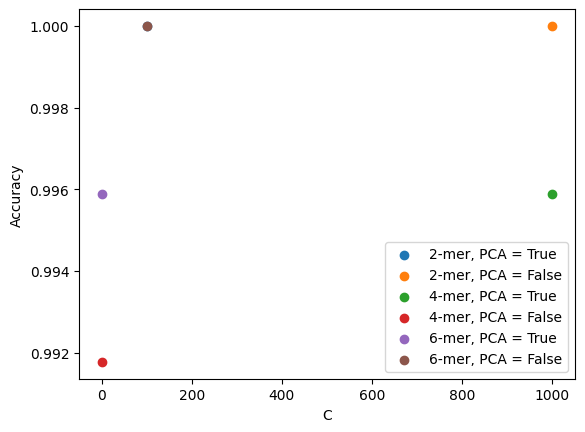

In [18]:
for i in range(len(results)):
    plt.scatter(results[i][1],results[i][0],label=results[i][3][0] + "-mer, PCA = " + str(results[i][3][1]))
plt.legend() 
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.savefig("Cross_Val")

In [8]:
C = []
N_var = []
Acc = []
k_mer = []
princ = []
for i in range(len(results)):
    C.append(results[i][1])
    Acc.append(results[i][0])
    N_var.append(results[i][2])
    k_mer.append(results[i][3][0])
    princ.append(results[i][3][1])
Extra = pd.DataFrame({'k-mer':k_mer, 'PCA': princ, 'C': C, 'Accuracy': Acc, 'Number of variables': N_var})

In [9]:
Extra

,k-mer,PCA,C,Accuracy,Number of variables
0,2,True,1000.0,1.000000,13
1,2,False,1000.0,1.000000,15
2,4,True,1.0,0.995885,6
